# Localization_Classification.ipynb
Date: December 2nd, 2018  
Course: ECSE415, McGill University  
Authors:  
*Shawn Vosburg  
Tristan Bouchard  
Alex Masciotra  
Nayem Alam  
Thomas Philippon *

## 3. Localization & Classification

In [1]:
#Import the required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, os.path
import time
import  random as rand
from sklearn.externals import joblib
import csv

#Constants
CLASSIFY_DIM = (128,128)
vehicleName = [
    "articulated_truck", "background", "bicycle",
    "bus", "car", "motorcycle", "non-motorized_vehicle",
    "pedestrian", "pickup_truck", "single_unit_truck", "work_van"                
]
NUM_VALIDATION_SET = 10 #There will be 10 validation sets
NUM_IMG_PER_SET = 30    #There will be 30 images per set

#Make directory if necessary
localizerPath = "./Localizer/"
if(not os.path.isdir(localizerPath)):
    os.makedirs(localizerPath)

## Load Classifiers

In [2]:
#Loading classifier for use in predicting if image is vehicle.  
loadingPath = "./Classifiers/SVM/"
clfFileType = ".clf"
name = "SVMclf"+ "_Main"
path = loadingPath + name +clfFileType
print("Presently loading classifier SVM...",end="")
start = time.time()
clfSVM = joblib.load(path)
end = time.time()
print("DONE! (Time taken:",end-start,"sec)")

loadingPath = "./Classifiers/Kneigh/"
clfFileType = ".clf"
name = "Kneighclf"+ "_Main"
path = loadingPath + name +clfFileType
print("Presently loading classifier Kneigh...",end="")
start = time.time()
clfKneigh = joblib.load(path)
end = time.time()
print("DONE! (Time taken:",end-start,"sec)")


Presently loading classifier SVM...DONE! (Time taken: 4.658222198486328 sec)
Presently loading classifier Kneigh...DONE! (Time taken: 1.071892261505127 sec)


## Useful Functions/Classes

In [3]:
def HoGFromImage(img,cs,bs,nb):
    """ This function takes in an image array and HoG param and returns the computed histogram for the image array
        img = image array. all images must be same resolution. 
        cs = cell size in pixel x pixel (height x width)
        bc = bin size in cell x cell (height x width)
        nb = number of bins

    """

    # create HoG Object
    # winSize is the size of the image cropped to an multiple of the cell size
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cs[1] * cs[1],
                                      img.shape[0] // cs[0] * cs[0]),
                            _blockSize=(bs[1] * cs[1],
                                        bs[0] * cs[0]),
                            _blockStride=(cs[1], cs[0]),
                            _cellSize=(cs[1], cs[0]),
                            _nbins=nb)
    
    
    n_cells = (img.shape[0] // cs[0], img.shape[1] // cs[1])
        

    # Compute HoG features
    hog_feats = hog.compute(img)\
                   .reshape(n_cells[1] - bs[1] + 1,
                            n_cells[0] - bs[0] + 1,
                            bs[0], bs[1], nb) \
                   .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

    # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    #Add each contributions to the histogram.
    for off_y in range(bs[0]):
        for off_x in range(bs[1]):
            gradients[off_y:n_cells[0] - bs[0] + off_y + 1,
                      off_x:n_cells[1] - bs[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - bs[0] + off_y + 1,
                       off_x:n_cells[1] - bs[1] + off_x + 1] += 1

    # Average gradients
    gradients /= cell_count
    return gradients

#Class containging the rectangle shape
class rectangle():
    """
    Class containing the information of a general rectangle. 
    """
    def __init__(self,x,y,w,h,color = (0,0,0)):
        """
        x = X-coord of top left
        y = y-coord of top left
        w = width of rectangle
        h = height of rectangle
        color = color to display on screen when printed. 
        """
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.color = color
    def print(self):
        print(self.x,self.y,self.w,self.h)

#Class to keep the images numbered. Used for accessing csv data later. 
class localizedImage():
    """
    Class will keep image with its name and its bounding rectangles
    """
    def __init__(self,img,name,predRect = None ,gtRect = None,dice_list = None, meanDice = None,accuracy = None, precision = None, recall = None):
        """
        img = img data
        name = name of the image (e.g. 00000001)
        predRect = 
        """
        self.img = img
        self.name = name
        self.predRect = predRect
        self.gtRect = gtRect
        self.dice_list = dice_list
        self.meanDice = meanDice
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

#When passing an image, will attempt to find the vehicles in the image 
def slidingWindow(img):
    """
    This function returns a list of sliding windows based on the image's shape. 
    """
    #Create copy of img to return
    img1 = img.copy()
    #Intialize variables
    windows = []
    scaleFactor = 1.4
    squareSize = 60
    overlap = 0.6
    color = [[255,0,0],[0,255,0],[0,0,255]]
    initialSizeOfRectangles = [  #Convention is [xwin,ywin,wwin,hwin]
        [0,0,int(squareSize/342 * img.shape[1]),int(squareSize/342 * img.shape[1]),color[0]], #SQUARE
        [0,0,int(2/ np.sqrt(6) *squareSize/342 * img.shape[1]),int(3/ np.sqrt(6) *squareSize/342 * img.shape[1]),color[1]], #VERTICAL RECTANGLE
        [0,0,int(3/ np.sqrt(6) *squareSize/342 * img.shape[1]),int(2/ np.sqrt(6) *squareSize/342 * img.shape[1]),color[2]], #HORIZONTAL RECTANGLE
    ]
    
    #Build sliding windows
    for inital in initialSizeOfRectangles:
        xwin = inital[0]
        ywin = inital[1]
        wwin = inital[2]
        hwin = inital[3]
        col = inital[4]
        layer = 0
        
        while ywin < img.shape[1]:
            for xwin in range(0,img.shape[1],int(wwin*(1.0 - overlap))):
                #Ignore the first layer as the windows will be too small
                if(layer == 0):
                    continue
                
                #If the outside of the sliding window is cut off, ignore window
                if (img.shape[1] - xwin) < wwin or (img.shape[0] - ywin) < hwin :
                    continue
                
                #Create window and append to list
                patch = rectangle(xwin,ywin,wwin,hwin,col)
                cv2.rectangle(img1, (xwin,ywin),(xwin+wwin-1,ywin+hwin-1),col,2)
                windows.append(patch)

            #Update sliding window parameters
            ywin = int(ywin + hwin*(1.0-overlap))
            hwin = int(hwin * scaleFactor)
            wwin = int(wwin * scaleFactor)
            layer += 1

    return windows,img1

def find_predRect(img):
    """
    Runs the image with the sliding windows in the classifiers
    Returns the bounding boxes of the detected rectangles and the image displaying the rectangles on them.
    """
    cs = (8,8)
    bs = (2,2)
    nbins = 8
    boundingRect = []
    img1 = img.copy()
    windows,_ = slidingWindow(img)
    for sw in windows:
        patch = img[sw.y:sw.y + sw.h, sw.x:sw.x + sw.w] 
        patch = cv2.resize(patch,CLASSIFY_DIM)
        hog = HoGFromImage(patch,cs,bs,nbins)
        hog = hog.reshape(1,-1)
        labelKneigh = clfKneigh.predict(hog)
        labelSVM = clfSVM.predict(hog)

        #Build Mix Picture
        if(labelKneigh != 1 and labelKneigh != 7 and labelKneigh == labelSVM):
            boundingRect.append(sw)
            cv2.rectangle(img1, (sw.x, sw.y) ,(sw.x + sw.w-1, sw.y + sw.h-1), sw.color, 3)
            #cv2.putText(img1,vehicleName[labelKneigh[0]] ,(sw.x,sw.y-7), cv2.FONT_HERSHEY_SIMPLEX, 1,sw.color,2,cv2.LINE_AA)
    return boundingRect, img1

def fill_predRect(image_matrix):
    """
    Function:    fill_predRect(image_matrix)
    Description: Function to compute the DICE coefficients of a matrix of test images
    Parameters:  image_matrix -  Matrix of objects of class numberedImages() of dimension
                                 10 rows by 30 columns
    
    Returns:     image_matrix - Matrix of objects of class numberedImages(), with the same dimensions
                                as the initial input matrix
                 
    Created by:  Tristan Bouchard, Shawn Vosburg
    Date:        2018-11-27
    """
    # Get input images, in a matrix of size 10 buckets (rows) by 30 columns (images in buckets)
    # For each bucket
    for i in range(len(image_matrix)):
        # For each image in bucket
        bucket = image_matrix[i]
        for j in range(len(image_matrix[0])):
            img = bucket[j]
            # Compute bounding rectangles for particular image
            predRect, _ = find_predRect(img.img)
            # Append predRect list to numberedImage() predRect field
            img.predRect = predRect
        
    return image_matrix

def load_images(path, num_buckets, img_per_bucket):
    """
    Function:    load_images(path, num_buckets, img_per_bucket)
    Description: Function to load images into matrix and initialise matrix of numberedImage() class
    Parameters:  path  ---------- Path to the input images
                 num_buckets ---- Number of buckets in which to separate images --> Becomes a row in the matrix
                 img_per_bucket - Number of images for each bucket --> Fills in a column in the matrix
    
    Returns:     image_matrix - Matrix of objects of class numberedImages(), with dimensions specified
                                as arguments
                 
    Created by:  Tristan Bouchard, Shawn Vosburg
    Date:        2018-11-27
    """
    img_index = 0
    img_list = os.listdir(path)
    
    # Create list of images
    image_matrix = [None]*num_buckets
    for i in range(num_buckets):
        l = [None]*(img_per_bucket)
        image_matrix[i] = (l)
    
    for i in range(num_buckets):
        for j in range(img_per_bucket):
            name = img_list[img_index]
            #img = cv2.imread(os.path.join(path,name))
            img = cv2.imread(path + "/" + name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Remove extension from image name
            name = name[:-4]
            
            # Initialize localisedImage object
            loc_img = localizedImage(img,name)
            
            image_matrix[i][j] = loc_img
            img_index = img_index + 1
    
    return image_matrix

#function reading a .csv file and creating a rectangle object from the GT table
def get_gt(img_id, csv_datapath):
    
    """Function that takes an image from the dataset and the GT csv file and returns an array of rectangles each detected object on the image 
    ----------
    img_id : image name (name of the file) 
    csv_file : csv file read using the csv.read function
    Returns 
    -------
    rectangle_list : list of rectangle objects for each detected object on the image 
    """
    #create the list of rectangles object 
    rectangle_list = []
    
    #open the csv file and retrieve the gt
    with open(csv_datapath) as f: 
        reader = csv.reader(f)
        for i in reader:
            if(i[0] == img_id): 
                rect = rectangle(x = i[2], y = i[4] , h = i[3] ,w = i[5])
                rectangle_list.append(rect)
    
    return rectangle_list 


#function to compute the dice coefficients 
def dice_coef(image_matrix, csv_datapath):
    
    """Function that takes the detected windows from the localization algorithm and computes the dice coefficients using the gt table
       The groung truth rectangles are retrived from the .csv file 
    ----------
    image_matrix -  Matrix of objects of class numberedImages() 
    csv_datapath : datapath to the folder where the csv file is 
    
    Returns 
    -------
    dice_list : dice coefficient for each ground truth image 
    """
    #For each bucket 
    for i in range(len(image_matrix)):
        # For each image in bucket
        bucket = image_matrix[i]
        print("Presently finding DICE coefficient of validation set",i+1,"/",len(image_matrix),"...", end = "")
        start = time.time()
        for j in range(len(image_matrix[0])):
            locImg = bucket[j]
            pred_list = locImg.predRect
            img_shape = locImg.img.shape
            img_tag   = locImg.name

            #create the list of ground truth rectangles object 
            gt_list = []

            #open the csv file and retrieve the gt
            with open(csv_datapath) as f: 
                reader = csv.reader(f)
                for i in reader:
                    if(i[0] == img_tag): 
                        tlx = int(i[2])
                        tly = int(i[3])
                        brx = int(i[4])
                        bry = int(i[5])
                        rect = rectangle(tlx,tly,brx-tlx,bry-tly)
                        gt_list.append(rect)
            
            #Put in the groundTruth rectangles to the localized image so that we keep it in memory
            locImg.gtRect = gt_list
            
            #now that the ground truth recangles have been retreived from the .csv file, compute the dce coeff. 
            #list of Dice coefficient for the detected rectangles
            dice_list = []
            accuracy = []
            precision = []
            recall = []
            areaArr = []
            for gt in range(len(gt_list)): 
                gt_img = np.zeros(img_shape)
                dice_max = []
                accuracyMax = []
                precisionMax = []
                recallMax = []

                #retrieve the ground truth rectangle parameters
                gt_x = int(gt_list[gt].x)
                gt_y = int(gt_list[gt].y)
                gt_w = int(gt_list[gt].w)
                gt_h = int(gt_list[gt].h)

                #draw the filled rectangle for the ground truth rectangle  
                cv2.rectangle(gt_img, (gt_x, gt_y), (gt_x + gt_w -1, gt_y + gt_h -1), (1.0,1.0,1.0), -1)

                for pred in range(len(pred_list)): 
                    TP_img = np.zeros(img_shape)
                    FP_img = np.zeros(img_shape)
                    FN_img = np.zeros(img_shape)
                    flat = np.zeros([0,img_shape[0]*img_shape[1]])
                    pred_img = np.zeros(img_shape)

                    #retrieve the predicted rectangle parameters
                    pred_x = int(pred_list[pred].x)
                    pred_y = int(pred_list[pred].y)
                    pred_w = int(pred_list[pred].w)
                    pred_h = int(pred_list[pred].h)

                    #draw the filled rectangle for the predicted rectangle 
                    cv2.rectangle(pred_img, (pred_x, pred_y), ((pred_x + pred_w -1), (pred_y + pred_h -1)), (1.0, 1.0, 1.0), -1)  

                    #TP is the multiplication of the two images, since the rectangle region is 1 and the rest 0 (like a bitwise AND for each pixel )
                    TP_img = gt_img * pred_img
                    TP = sum(TP_img.flatten())

                    #FP is the predicted image minus TP 
                    FP_img = pred_img - TP_img
                    FP = sum(FP_img.flatten())

                    #FN is the predicted image minus TP 
                    FN_img = gt_img - TP_img
                    FN = sum(FN_img.flatten())
                    
                    #TN is the total image minus TP,FP,FN
                    TN = img_shape[0] * img_shape[1] - TP - FP - FN

                    #compute the DICE coefficient 
                    dice_max.append((2*TP)/(2*TP+FN+FP))
                    
                    #Find Accuracy,precision,recall
                    accuracyMax.append((TP + TN)/(TP+TN+FN+FP))
                    precisionMax.append(TP/(TP+FP))
                    recallMax.append(TP/(TP+FN))
                    
                areaArr.append(sum(gt_img.flatten()))
                #Take care of case where we did not predict a vehicle in the image
                if(len(dice_max) != 0 ):
                    dice_list.append(max(dice_max))
                    indexOfMax = np.argmax(dice_max)
                    accuracy.append(accuracyMax[indexOfMax]) 
                    precision.append(precisionMax[indexOfMax])
                    recall.append(recallMax[indexOfMax])
                else:
                    dice_list.append(0)
                    accuracy.append((gt_w*gt_h)/(img_shape[0] * img_shape[1])) 
                    precision.append(0)
                    recall.append(0)

            #Find the weighted-by-area average dice coeff for the image
            sumArea = sum(areaArr)
            averageDice = [dice_list[i]*areaArr[i] /sumArea for i in range(int(len(areaArr)))]
            
            #Save values inside the localized images
            locImg.dice_list = dice_list
            locImg.accuracy = accuracy
            locImg.precision = precision
            locImg.recall = recall
            locImg.meanDice = sum(averageDice)
            
        #Print out that the Dice coefficient of this particular bin has been calculated
        end = time.time()
        print("DONE! (Time Taken:",end-start,"sec)")
            
    return image_matrix


## Read in Images and find DICE coefficients (Random 300)

In [4]:
#Verify that the job isn't already saved.
fileName = "ResultRandom300"
fileType = ".loc"
loadingpath = localizerPath+fileName+fileType
if(not os.path.isfile(loadingpath)):
    print("Loading images and localizing vehicles in them...",end = "")
    #Load images
    path = "./MIO-TCD-Localization/MIO-TCD-Localization/train/"
    start = time.time()
    imgArr = load_images(path, NUM_VALIDATION_SET, NUM_IMG_PER_SET)
    #Find the prediction rectangles where the classifiers believe there is an object of interest
    imgArr = fill_predRect(imgArr)
    print("DONE! (Total time taken:",end-start,"sec)")

    #Fetch the ground truth rectangles and calculate the DICE coeffs.
    csv_datapath =  "./MIO-TCD-Localization/MIO-TCD-Localization/gt_train.csv"
    imgArr = dice_coef(imgArr, csv_datapath)
    end = time.time()
    
    joblib.dump(imgArr,loadingpath)

#If the job has already been saved, just load in the imgArr
else:
    print("Loading previously saved Localizer result for Random300...",end="")
    start = time.time()
    imgArr = joblib.load(loadingpath)
    end = time.time()
    print("DONE! (Time taken:",end-start,"sec)")

Loading previously saved Localizer result for Random300...DONE! (Time taken: 0.42717456817626953 sec)


#### Example Result

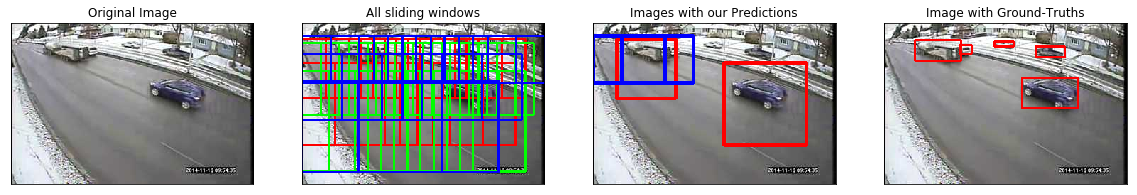

Report for ground truth rectangle located at [Top Left = (213 , 34 )	Bottom Right = ( 254 , 49 )] :
	DICE Coefficient = 0.000
	Accuracy = 0.703
	Precision = 0.000
	Recall = 0.000
Report for ground truth rectangle located at [Top Left = (194 , 78 )	Bottom Right = ( 272 , 121 )] :
	DICE Coefficient = 0.405
	Accuracy = 0.607
	Precision = 0.254
	Recall = 1.000
Report for ground truth rectangle located at [Top Left = (155 , 27 )	Bottom Right = ( 182 , 34 )] :
	DICE Coefficient = 0.000
	Accuracy = 0.720
	Precision = 0.000
	Recall = 0.000
Report for ground truth rectangle located at [Top Left = (43 , 25 )	Bottom Right = ( 108 , 54 )] :
	DICE Coefficient = 0.449
	Accuracy = 0.813
	Precision = 0.290
	Recall = 1.000
Report for ground truth rectangle located at [Top Left = (106 , 32 )	Bottom Right = ( 123 , 44 )] :
	DICE Coefficient = 0.066
	Accuracy = 0.746
	Precision = 0.034
	Recall = 1.000
The equally-weighted average DICE coefficient: 	0.184
The area-weighted average DICE coefficient: 	0.351


In [5]:
locImg = imgArr[0][0]
img = locImg.img
#Display all sliding windows in the image
_,img3 = slidingWindow(img)
#Detect the vehicles in the images
_ , img1 = find_predRect(img) #This function runs our localizer

#Building the ground truth rectangles on the image
img2 = img.copy()
gt_rect = locImg.gtRect
for rect in gt_rect:
    cv2.rectangle(img2, (rect.x, rect.y), (rect.x + rect.w-1, rect.y + rect.h -1), (255,0,0), 2)

plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(img)
plt.title("Original Image")
plt.xticks([]), plt.yticks([])
plt.subplot(142)
plt.imshow(img3)
plt.title("All sliding windows")
plt.xticks([]), plt.yticks([])
plt.subplot(143)
plt.imshow(img1)
plt.xticks([]), plt.yticks([])
plt.title("Images with our Predictions")
plt.subplot(144)
plt.imshow(img2)
plt.xticks([]), plt.yticks([])
plt.title("Image with Ground-Truths")
plt.show()

#Displaying the Dice Coefficient for each ground truth rectangle
for (diceCoeff,rect,accuracy,precision,recall) in zip(locImg.dice_list,locImg.gtRect,locImg.accuracy,locImg.precision,locImg.recall):
    print("Report for ground truth rectangle located at [Top Left = (",end="")
    print(rect.x,",",rect.y,")\tBottom Right = (",rect.x+rect.w-1,",",rect.y+rect.h-1,")] :")
    print("\tDICE Coefficient =","{:.{}f}".format( diceCoeff, 3 ))
    print("\tAccuracy =","{:.{}f}".format( accuracy, 3 ))
    print("\tPrecision =","{:.{}f}".format( precision, 3 ))
    print("\tRecall =","{:.{}f}".format( recall, 3 ))
    

print("The equally-weighted average DICE coefficient:", "\t{:.{}f}".format( np.mean(locImg.dice_list), 3 ))
print("The area-weighted average DICE coefficient:", "\t{:.{}f}".format( locImg.meanDice, 3 ))
print("The average accuracy is:", "\t\t\t{:.{}f}".format( np.mean(locImg.accuracy), 3 ))
print("The average precision is:", "\t\t\t{:.{}f}".format( np.mean(locImg.precision), 3 ))
print("The average recall is:", "\t\t\t\t{:.{}f}".format( np.mean(locImg.recall), 3 ))

In [6]:
#Find distribution of Localizer DICE coefficients, Accuracy, Precision, Recall across validation set
idx = 1
for bucket in imgArr:
    print("Report for validation set",idx,"/",len(imgArr),":")
    print("\tDICE Coefficient =","{:.{}f}".format( np.mean([np.mean(locImg.dice_list) for locImg in bucket]), 3 ))
    print("\tAccuracy =","{:.{}f}".format( np.mean([np.mean(locImg.accuracy) for locImg in bucket]), 3 ))
    print("\tStandardDev Accuracy =","{:.{}f}".format( np.std([np.mean(locImg.accuracy) for locImg in bucket]), 3 ))
    print("\tPrecision =","{:.{}f}".format( np.mean([np.mean(locImg.precision) for locImg in bucket]), 3 ))
    print("\tRecall =","{:.{}f}".format( np.mean([np.mean(locImg.recall) for locImg in bucket]), 3 ))
    idx += 1

print("\nSUMMARY OF LOCALIZER WITH INPUT OF RANDOM 300:")
print("\tDICE Coefficient =","{:.{}f}".format( np.mean([np.mean([np.mean(locImg.dice_list) for locImg in bucket]) for bucket in imgArr]), 3 ))
print("\tSTD DICE =","{:.{}f}".format( np.mean([np.mean([np.mean(locImg.dice_list) for locImg in bucket]) for bucket in imgArr]), 3 ))
print("\tAccuracy =","{:.{}f}".format( np.mean([np.mean([np.mean(locImg.accuracy) for locImg in bucket]) for bucket in imgArr]), 3 ))
print("\tStandardDev Accuracy=","{:.{}f}".format( np.std([np.mean([np.mean(locImg.accuracy) for locImg in bucket]) for bucket in imgArr]), 3 ))
print("\tPrecision =","{:.{}f}".format( np.mean([np.mean([np.mean(locImg.precision) for locImg in bucket]) for bucket in imgArr]), 3 ))
print("\tRecall =","{:.{}f}".format( np.mean([np.mean([np.mean(locImg.recall) for locImg in bucket]) for bucket in imgArr]), 3 ))

Report for validation set 1 / 10 :
	DICE Coefficient = 0.161
	Accuracy = 0.441
	StandardDev Accuracy = 0.273
	Precision = 0.129
	Recall = 0.341
Report for validation set 2 / 10 :
	DICE Coefficient = 0.090
	Accuracy = 0.506
	StandardDev Accuracy = 0.212
	Precision = 0.068
	Recall = 0.321
Report for validation set 3 / 10 :
	DICE Coefficient = 0.109
	Accuracy = 0.461
	StandardDev Accuracy = 0.271
	Precision = 0.098
	Recall = 0.334
Report for validation set 4 / 10 :
	DICE Coefficient = 0.213
	Accuracy = 0.526
	StandardDev Accuracy = 0.243
	Precision = 0.201
	Recall = 0.418
Report for validation set 5 / 10 :
	DICE Coefficient = 0.144
	Accuracy = 0.488
	StandardDev Accuracy = 0.259
	Precision = 0.103
	Recall = 0.445
Report for validation set 6 / 10 :
	DICE Coefficient = 0.149
	Accuracy = 0.471
	StandardDev Accuracy = 0.284
	Precision = 0.138
	Recall = 0.348
Report for validation set 7 / 10 :
	DICE Coefficient = 0.086
	Accuracy = 0.381
	StandardDev Accuracy = 0.267
	Precision = 0.112
	Recall 

## Read in Images and find DICE coefficients (Best 300 of first 1000)

In [7]:
#Verify that the job isn't already saved.
fileName = "Result1000"
fileType = ".loc"
loadingpath = localizerPath+fileName+fileType
if(not os.path.isfile(loadingpath)):
    print("Loading images and localizing vehicles in them...",end = "")
    #Load images
    path = "./MIO-TCD-Localization/MIO-TCD-Localization/train/"
    start = time.time()
    #Must change the number of img per set to 100
    numImgPerSet = 100
    imgArr = load_images(path, NUM_VALIDATION_SET, numImgPerSet)
    #Find the prediction rectangles where the classifiers believe there is an object of interest
    imgArr = fill_predRect(imgArr)
    print("DONE! (Total time taken:",end-start,"sec)")

    #Fetch the ground truth rectangles and calculate the DICE coeffs.
    csv_datapath =  "./MIO-TCD-Localization/MIO-TCD-Localization/gt_train.csv"
    imgArr = dice_coef(imgArr, csv_datapath)
    end = time.time()
    
    joblib.dump(imgArr,loadingpath)

#If the job has already been saved, just load in the imgArr
else:
    print("Loading previously saved Localizer result for First1000...",end="")
    start = time.time()
    imgArr = joblib.load(loadingpath)
    end = time.time()
    print("DONE! (Time taken:",end-start,"sec)")

Loading previously saved Localizer result for First1000...DONE! (Time taken: 1.3989477157592773 sec)


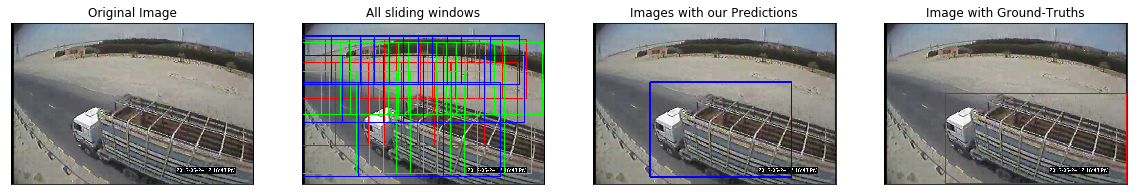

Report for ground truth rectangle located at [Top Left = (182 , 211 )	Bottom Right = ( 717 , 478 )] :
	DICE Coefficient = 0.771
	Accuracy = 0.478
	Precision = 0.853
	Recall = 0.703
The equally-weighted average DICE coefficient: 	0.771
The area-weighted average DICE coefficient: 	0.771
The average accuracy is: 			0.478
The average precision is: 			0.853
The average recall is: 				0.703


In [8]:
#Find best 300 image that have the highest mean dice
flatImgArr = np.asarray(imgArr).reshape(-1)
sortedArr = sorted(flatImgArr, key=lambda x: np.mean(x.dice_list), reverse=True)[:300]
sortedArr = np.asarray(sortedArr).reshape((NUM_VALIDATION_SET,NUM_IMG_PER_SET ))

#Obtain example image in first bin
locImg = sortedArr[0][3]
img = locImg.img
#Display all sliding windows in the image
_,img3 = slidingWindow(img)
#Detect the vehicles in the images
_ , img1 = find_predRect(img) #This function runs our localizer

#Building the ground truth rectangles on the image
img2 = img.copy()
gt_rect = locImg.gtRect
for rect in gt_rect:
    cv2.rectangle(img2, (rect.x, rect.y), (rect.x + rect.w-1, rect.y + rect.h -1), (255,0,0), 2)

plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(img)
plt.title("Original Image")
plt.xticks([]), plt.yticks([])
plt.subplot(142)
plt.imshow(img3)
plt.title("All sliding windows")
plt.xticks([]), plt.yticks([])
plt.subplot(143)
plt.imshow(img1)
plt.xticks([]), plt.yticks([])
plt.title("Images with our Predictions")
plt.subplot(144)
plt.imshow(img2)
plt.xticks([]), plt.yticks([])
plt.title("Image with Ground-Truths")
plt.show()

#Displaying the Dice Coefficient for each ground truth rectangle
for (diceCoeff,rect,accuracy,precision,recall) in zip(locImg.dice_list,locImg.gtRect,locImg.accuracy,locImg.precision,locImg.recall):
    print("Report for ground truth rectangle located at [Top Left = (",end="")
    print(rect.x,",",rect.y,")\tBottom Right = (",rect.x+rect.w-1,",",rect.y+rect.h-1,")] :")
    print("\tDICE Coefficient =","{:.{}f}".format( diceCoeff, 3 ))
    print("\tAccuracy =","{:.{}f}".format( accuracy, 3 ))
    print("\tPrecision =","{:.{}f}".format( precision, 3 ))
    print("\tRecall =","{:.{}f}".format( recall, 3 ))
    

print("The equally-weighted average DICE coefficient:", "\t{:.{}f}".format( np.mean(locImg.dice_list), 3 ))
print("The area-weighted average DICE coefficient:", "\t{:.{}f}".format( locImg.meanDice, 3 ))
print("The average accuracy is:", "\t\t\t{:.{}f}".format( np.mean(locImg.accuracy), 3 ))
print("The average precision is:", "\t\t\t{:.{}f}".format( np.mean(locImg.precision), 3 ))
print("The average recall is:", "\t\t\t\t{:.{}f}".format( np.mean(locImg.recall), 3 ))

In [9]:
#Find distribution of Localizer DICE coefficients, Accuracy, Precision, Recall across validation set
idx = 1
for bucket in sortedArr:
    print("Report for validation set",idx,"/",len(imgArr),":")
    print("\tDICE Coefficient =","{:.{}f}".format( np.mean([np.mean(locImg.dice_list) for locImg in bucket]), 3 ))
    print("\tAccuracy =","{:.{}f}".format( np.mean([np.mean(locImg.accuracy) for locImg in bucket]), 3 ))
    print("\tStandardDev Accuracy=","{:.{}f}".format( np.std([np.mean(locImg.accuracy) for locImg in bucket]), 3 ))
    print("\tPrecision =","{:.{}f}".format( np.mean([np.mean(locImg.precision) for locImg in bucket]), 3 ))
    print("\tRecall =","{:.{}f}".format( np.mean([np.mean(locImg.recall) for locImg in bucket]), 3 ))
    idx += 1

print("\nSUMMARY OF LOCALIZER WITH INPUT OF BEST 300 OF FIRST 1000:")
print("\tDICE Coefficient =","{:.{}f}".format( np.mean([np.mean([np.mean(locImg.dice_list) for locImg in bucket]) for bucket in sortedArr]), 3 ))
print("\tSTD DICE =","{:.{}f}".format( np.std([np.mean([np.mean(locImg.dice_list) for locImg in bucket]) for bucket in sortedArr]), 3 ))
print("\tAccuracy =","{:.{}f}".format( np.mean([np.mean([np.mean(locImg.accuracy) for locImg in bucket]) for bucket in sortedArr]), 3 ))
print("\tStandardDev Accuracy =","{:.{}f}".format( np.std([np.mean([np.mean(locImg.accuracy) for locImg in bucket]) for bucket in sortedArr]), 3 ))
print("\tPrecision =","{:.{}f}".format( np.mean([np.mean([np.mean(locImg.precision) for locImg in bucket]) for bucket in sortedArr]), 3 ))
print("\tRecall =","{:.{}f}".format( np.mean([np.mean([np.mean(locImg.recall) for locImg in bucket]) for bucket in sortedArr]), 3 ))

Report for validation set 1 / 10 :
	DICE Coefficient = 0.686
	Accuracy = 0.723
	StandardDev Accuracy= 0.154
	Precision = 0.667
	Recall = 0.787
Report for validation set 2 / 10 :
	DICE Coefficient = 0.516
	Accuracy = 0.606
	StandardDev Accuracy= 0.227
	Precision = 0.477
	Recall = 0.749
Report for validation set 3 / 10 :
	DICE Coefficient = 0.424
	Accuracy = 0.561
	StandardDev Accuracy= 0.260
	Precision = 0.355
	Recall = 0.738
Report for validation set 4 / 10 :
	DICE Coefficient = 0.360
	Accuracy = 0.557
	StandardDev Accuracy= 0.181
	Precision = 0.323
	Recall = 0.634
Report for validation set 5 / 10 :
	DICE Coefficient = 0.316
	Accuracy = 0.513
	StandardDev Accuracy= 0.207
	Precision = 0.255
	Recall = 0.745
Report for validation set 6 / 10 :
	DICE Coefficient = 0.277
	Accuracy = 0.575
	StandardDev Accuracy= 0.209
	Precision = 0.246
	Recall = 0.577
Report for validation set 7 / 10 :
	DICE Coefficient = 0.244
	Accuracy = 0.569
	StandardDev Accuracy= 0.187
	Precision = 0.191
	Recall = 0.580